In [64]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import json
import numpy as np
from tqdm.notebook import tqdm
from data_tools import get_data_with_dates, get_verified_data
from warnings import warn

sns.set(rc={"figure.figsize":(16, 10)})

In [2]:
def get_data(filename: str, crisis_start: pd.Timestamp):
    src_df = pd.read_excel(filename)
    
    new_cols = ['brak', 'negatywny', 'neutralny', 'pozytywny']
    new_cols_ex = [c for c in new_cols if c in src_df['Wydźwięk'].unique().tolist()]
    src_df[new_cols_ex] = pd.get_dummies(src_df['Wydźwięk'])
    for col in new_cols:
        if col not in src_df.columns:
            src_df[col] = 0

    df = src_df[['Data wydania'] + new_cols].groupby(['Data wydania']).sum()

    df = df.reindex(pd.date_range(df.index.min(), df.index.max()))
    df[new_cols] = df[new_cols].fillna(0)

    df['Liczba wpisów'] = df[new_cols].sum(axis=1)
    df['Kryzys'] = df.index >= crisis_start
    return df

def plot1(df: pd.DataFrame):
    ax = sns.lineplot(df[['Wydźwięk', 'Liczba wpisów']], x='Data wydania', y='Liczba wpisów', hue='Wydźwięk')
    ax.fill_between(df.index, 0, 1, where=df['Kryzys'], color='red', alpha=0.1, transform=ax.get_xaxis_transform())

def plot2(df: pd.DataFrame, title: str = None, prediction: pd.Timestamp = None):
    ax = plt.stackplot(x=df.index, data=df[['pozytywny', 'negatywny', 'neutralny', 'brak']])
    ax.fill_between(df.index, 0, 1, where=df['Kryzys'], color='red', alpha=0.1, transform=ax.get_xaxis_transform())
    if 'prediction' in df.columns:
        ax.fill_between(df.index, 0, 1, where=df['prediction'], color='blue', alpha=0.5, transform=ax.get_xaxis_transform())
    if title:
        ax.set_title(title)

In [3]:
def extract_raw_data(filename: str) -> pd.DataFrame:
    src_df = pd.read_excel(filename)

    if src_df['Kryzys'].hasnans:
        src_df['Kryzys'] = src_df['Kryzys'].notna()
    else:
        src_df['Kryzys'] = (src_df['Kryzys'] != 'NIE') & (src_df['Kryzys'] != 'Nie')
    if src_df['Kryzys'].nunique() != 2:
        warn(f'Crisis column data error in file {filename}.')
    
    new_cols = ['brak', 'negatywny', 'neutralny', 'pozytywny']
    new_cols_ex = [c for c in new_cols if c in src_df['Wydźwięk'].unique().tolist()]
    src_df[new_cols_ex] = pd.get_dummies(src_df['Wydźwięk'])
    for col in new_cols:
        if col not in src_df.columns:
            src_df[col] = 0

    df = src_df[['Data wydania', 'Kryzys']].groupby(['Data wydania']).any()
    df = df.join(src_df[['Data wydania'] + new_cols].groupby(['Data wydania']).sum())

    df = df.reindex(pd.date_range(df.index.min(), df.index.max()))
    df[new_cols] = df[new_cols].fillna(0)
    df['Kryzys'] = df['Kryzys'].fillna(method='ffill') & df['Kryzys'].fillna(method='bfill')

    # df['suma'] = df[new_cols].sum(axis=1)

    df['nazwa'] = os.path.basename(filename)[:-5]
    
    return df

In [4]:
from typing import NamedTuple


def plot3(row: NamedTuple, ):
    df = extract_raw_data(row.path)
    df = df[(df.index >= row.crisis_start - pd.Timedelta(days=30)) & (df.index < row.crisis_start + pd.Timedelta(days=30))]
    _, ax = plt.subplots()
    ax.stackplot(
        df.index.values,
        df[[ 'brak', 'negatywny', 'pozytywny', 'neutralny']].to_dict('list').values(),
        labels=['brak', 'negatywny', 'pozytywny', 'neutralny'],
        colors=['gray', 'red', 'green', 'blue'],
        edgecolor='face'
    )
    ax.fill_between(df.index, 0, 1, where=df['Kryzys'], color='red', alpha=0.1, transform=ax.get_xaxis_transform())
    ax.fill_between(df.index, 0, 1, where=(df.index == row.crisis_start), color='black', alpha=1, transform=ax.get_xaxis_transform())
    ax.legend()
    ax.set_title(os.path.basename(row.name))

In [65]:
def plot4(row: NamedTuple, ):
    df = extract_raw_data(row.path)
    df = df[(df.index >= row.crisis_start - pd.Timedelta(days=30)) & (df.index < row.crisis_start + pd.Timedelta(days=30))]
    _, ax = plt.subplots()
    ax.stackplot(
        df.index.values,
        df[[ 'brak', 'negatywny', 'pozytywny', 'neutralny']].to_dict('list').values(),
        labels=['brak', 'negatywny', 'pozytywny', 'neutralny'],
        colors=['gray', 'red', 'green', 'blue'],
        edgecolor='face'
    )
    ax.fill_between(df.index, 0, .5, where=df['Kryzys'], color='red', alpha=0.1, transform=ax.get_xaxis_transform())
    ax.fill_between(df.index, 0, .5, where=(df.index == row.crisis_start), color='darkred', alpha=1, transform=ax.get_xaxis_transform())
    if type(row.pred) == np.ndarray:
        pred = [0] * (len(df) - len(row.pred)) + row.pred.tolist()
        ax.fill_between(df.index, .5, 1, where=pred, color='blue', alpha=0.1, transform=ax.get_xaxis_transform())
        ax.fill_between(df.index, .5, 1, where=(df.index == row.crisis_start + pd.Timedelta(days=row.shift)), color='darkblue', alpha=1, transform=ax.get_xaxis_transform())
    ax.legend()
    ax.set_title(os.path.basename(row.name))

In [5]:
data = get_data_with_dates(get_verified_data())
pred_df = pd.read_feather('saved_objects/predictions.feather')

/home/proto/repos/crisis-detector/data_tools.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['path'] = data1['Nazwa pliku'].apply(lambda x: files[fnames.index(x)])


In [6]:
pred_df[pred_df['name'].duplicated(keep=False)]

,name,pred,shift


In [14]:
data = data.join(pred_df.set_index(['name']), on='name', how='left')

In [10]:
pred_df.iloc[13]['pred']

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [9]:
pred_df.iloc[14]['pred']

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [26]:
data.iloc[1].shift

<bound method Series.shift of name                                    Veclaim i "afera metkowa"
path             dane/Etap I - zweryfikowane szeregi/Veclaim.xlsx
crisis_start                                  2020-05-22 00:00:00
pred            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
shift                                                         3.0
Name: 1, dtype: object>

TypeError: float() argument must be a string or a real number, not 'method'

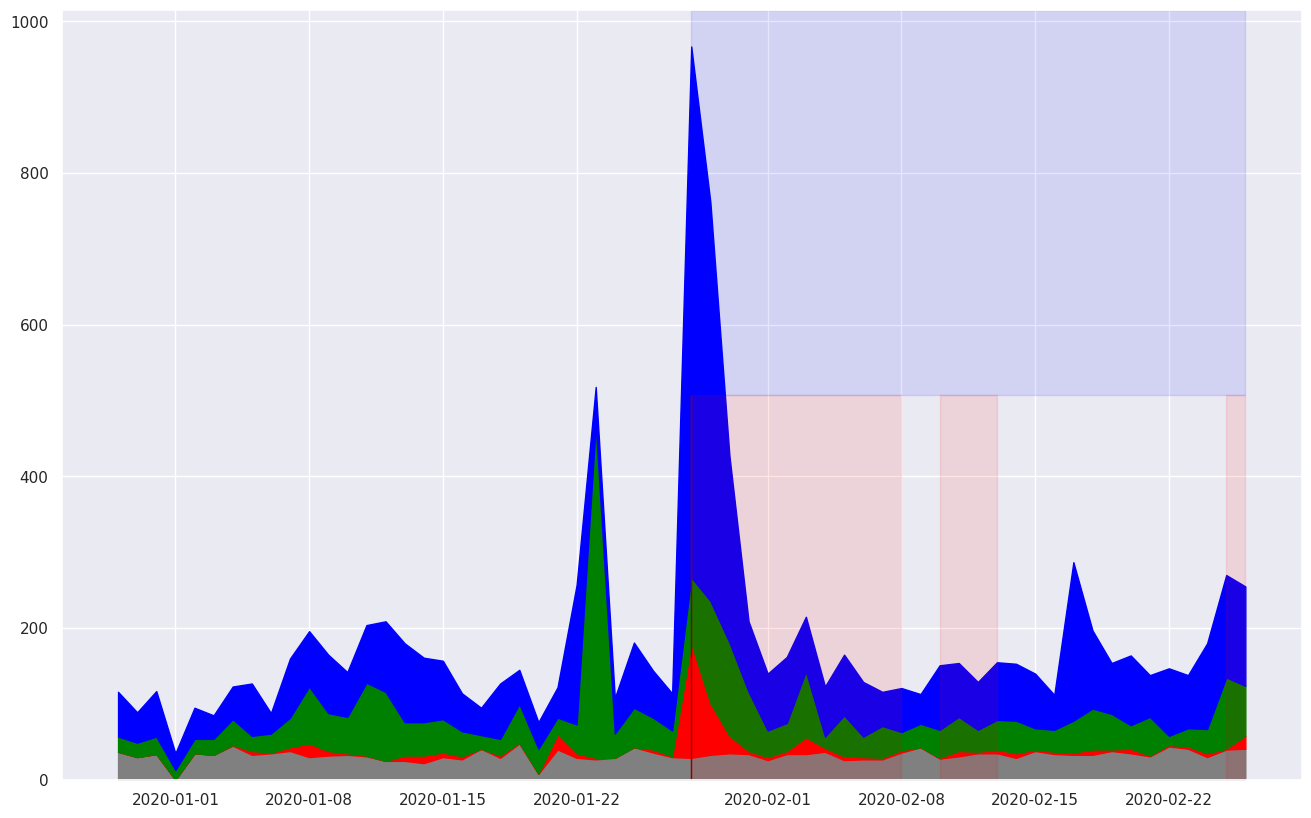

In [28]:
plot4(data.iloc[0])

In [57]:
import math

math.nan is math.nan

True

In [63]:
type(data.iloc[9]['pred']) == np.ndarray

False

In [41]:
data['pred'].iloc[0:20]

0     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
5     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
6     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
7     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
8     [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, ...
9                                                   NaN
10    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
11    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
12    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
13    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...
14    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
15    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
16    [0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
17    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [66]:
for row in tqdm(data.itertuples(), total=len(data)):
    try:
        plot4(row)
        plt.savefig(os.path.join('plots', os.path.basename(row.path)[:-5] + '.png'))
        plt.close()
    except KeyError:
        pass

  0%|          | 0/90 [00:00<?, ?it/s]

/tmp/ipykernel_7629/3953965445.py:9: UserWarning: Crisis column data error in file dane/Etap I - zweryfikowane szeregi/Ministerstwo Zdrowia_respiratory od handlarza bronią.xlsx.
  warn(f'Crisis column data error in file {filename}.')
